# Analizando el modelo de *regresión logística*

Antes de estudiar las probabilidades de compra de las barras de chocolate para cada segmento y para diferentes variaciones de precios, vamos a resumer qué es la *Regresión Logística*. Afortunadamente existe mucha bibliografía al respecto.

Luego aplicaremos un modelo de regresión para predecir la compra o no compra de las barras de chocolate. Entrenaremos el modelo considerando el precio *promedio* obtenido a partir de los datos que ya tenemos en las hojas csv.

## Regresión Logística

Vamos a utilizar la clase [Regresión Logística](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) de scikit-learn.

La Regresión logística es comunmente utilizada para *estimar la probabilidad de que una observación/instancia pertenezca a cierta clase*. En nuestro caso, lo que queremos es estimar *la probabilidad de compra de alguna de las marcas de barra de chocolate por parte de cierto cliente, perteneciente a cierto segmento en función del precio de la barra de chocolate*.

La ecuación en forma vectorizada de la regresión logística para determinar la probabilidad esta dada por,

$$ \hat{p} = h_{\theta}(\mathbf{x}) = \sigma \left( \theta^T\mathbf{x} \right)$$

Donde $\sigma$ representa la función *[sigmoide](https://en.wikipedia.org/wiki/Sigmoid_function)*, dada por,

$$ \sigma(t) = \frac{1}{1+exp(-t)} $$

Una vez que que se tiene la probabilidad de que una instancia pertenezca a la clase bajo estudio -**clase positiva**-, es fácil hacer una predicción para obtener $\hat{y}$. Por ejemplo, para un umbral del $50%$, la predicción nos daría,

$$ \hat{y}= \left\lbrace\begin{array}{c} 0~si~\hat{p}<0.5  \\ 1~si~\hat{p}\geq{0.5} \end{array}\right. $$

### Función de costo y entrenamiento

Necesitamos entrenar el modelo con nuestros datos para que, ante un nuevo cliente, intentemos predecir qué marca de barra de chocolate comprará. En el caso de regresión logística, la función de costo esta dada por,

$$ c(\theta)= \left\lbrace\begin{array}{c} -log(\hat{p})~si~y=1  \\ -log(1-\hat{p})~si~y=0 \end{array}\right. $$

#### Librerías a utilizar

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import pickle

from sklearn.linear_model import LogisticRegression 

import matplotlib.pyplot as plt
import matplotlib.axes as axs
import seaborn as sns
sns.set()

from sklearn.linear_model import LinearRegression

### Preparando datos

Antes que nada, debemos preparar o *pre-procesasr* los datos según hemos trabajado anteriormente. La idea de esto es poder procesar los datos para poder segmentar los clientes en las cuatro categorías que hemos visto y utilizarlos para el análisis.

In [2]:
#Cargamos los datos crudos
df_compras = pd.read_csv("datasets/purchase_data.csv")
# df_compras.head()
# print(df_compras.columns)

# Cargamos el modelo de escalamiento o scaler que entrenamos anteriormente.
scaler = pickle.load(open('models/scaler.pickle', 'rb'))

#  Cargamos el modelo de PCA
pca = pickle.load(open('models/pca.pickle', 'rb'))

# Cargamos el modelo PCA
kmeans_pca = pickle.load(open('models/kmeans_pca.pickle', 'rb'))

Ahora que tenemos los modelos cargados, vamos a procesar los datos.

In [3]:
## Aplicamos estandarización

features = df_compras[['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']]
df_compras_std = scaler.transform(features)

# Aplicamos PCA a los datos estandarizados
df_compras_pca = pca.transform(df_compras_std)

# Segmentamos los datos usando el modelo de KMeans entrenado previamente
segmentos = kmeans_pca.predict(df_compras_pca)

# Creamos una copia del dataframe original para trabajar sin modificar los datos del set original.
df_compras_predictor = df_compras.copy()

# Agregamos labels
df_compras_predictor["Segmento"] = segmentos

segmentos_dummies = pd.get_dummies(segmentos, prefix = 'Segmento', prefix_sep = '_')
df_compras_predictor = pd.concat([df_compras_predictor, segmentos_dummies], axis = 1)

# df_compras_predictor.head()

##### Importante
Es conveniente usar el método [Pipline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) de Scikit-learn para el procesamiento de los datos.

## Modelo para predicción de compras

Bien, para entrenar un modelo necesitamos una (o más) variable independiente y una (o más) variable dependiente.

En nuestro caso, sabemos que las compras de cierta barra se dió si la columna *Incidence* es igual a uno. Usaremos dicha columna como $Y$, es decir, variable dependiente. Por otro lado, vamos a usar el *promedio de precios* (desde precio 1 a precio 5) para utilizarlo como variable independiente, es decir, $X$. Con esto, intentaremos predecir la compra o no de una barra de chocolate para un rango de precios que definiremos y así estimar el comportamiento de un cliente *promedio* ante la compra de barras de chocolates en función de las 5 marcas dentro del set de datos.

In [4]:
# Variable dependiente
Y = df_compras_predictor["Incidence"]

# Variable independiente
X = pd.DataFrame(df_compras_predictor[['Price_1', 'Price_2', 'Price_3', 'Price_4','Price_5']].mean(axis=1), columns = ["precio"])
X.head()

,precio
0,2.044
1,2.028
2,2.028
3,2.028
4,2.030


In [5]:
lr_predictor = LogisticRegression(solver = "sag")
lr_predictor.fit(X,Y) #entrenamos el modelo

LogisticRegression(solver='sag')

La clase *LogisticRegression()* nos estima la probabilidad de compra.

Uno de los atributos dentro del objeto *lr_predictor* es *coef_*. El mismo representa el (o los coeficientes) que obtuvo el modelo al entrenarse con los datos dentro de $X$. Dicho coeficiente es parte de la ecuación que hemos mencionado arriba y se obtiene al resolver y disminuir la función de costo.

En nuestro caso, el coeficiente representa el *precio medio* de compra de las cinco marcas de barras de chocolate que utiliza el modelo para realizar las etimaciones (cálculo de probabilidades).

In [6]:
lr_predictor.coef_

array([[-2.34794675]])

Vemos que el valor del coeficiente es $-2.34$ lo cual implica que **un decremento en el precio implica un incremento en la probabilidad de compra**. Esto último no nos aporta nada nuevo, es algo intuitivo.

No obstante, es importante que tengamos en cuenta que este modelo cuantifica la relación entre el *precio* y la *probabilidad de compra*.

Veamos la dirección (si aumenta o disminuye) y la magnitud de cambio en la probabilidad de compra al cambiar el precio.

## Elasticidad de precio respecto de la probabilidad de compra

Aquí se dejan algunos artículos acerca de qué es la elasticidad de precio.

- [What Is Price Elasticity?](https://365datascience.com/trending/price-elasticity/)
- [Step By Step Analyzing Price Elasticity With Promotion Feature Against Purchase Probability](https://medium.com/@miradzji/purchase-probability-analysis-in-certain-market-segments-with-python-b346654ea5ec)
- [Price Elasticity: How Vulnerable Is Your Product In The Market?](https://affine.ai/price-elasticity-how-vulnerable-is-your-product-in-the-market/)

Según [wikipedia](https://es.wikipedia.org/wiki/Elasticidad_precio_de_la_demanda),
>   "*la elasticidad en el precio de la demanda es una medida utilizada en economía para mostrar el grado de respuesta, o elasticidad, de la cantidad demandada de un bien o servicio a los cambios en el precio de dicho bien o servicio*".

### Fórmula de elassticidad

Recordemos que la elasticidad está definida matemáticamente cómo,

$$ E = \frac{\frac{\Delta~P(compra)}{P(compra)}}{\frac{\Delta~Precio}{Precio}} = \frac{\Delta~P(compra)}{{\Delta~Precio}}\times\frac{Precio}{P(compra)}$$

Donde $\Delta$ implica una *diferencia* y $P(compra)$ es la *probabilidad de compra*. Por ejemplo, $\Delta Precio = Precio_{t} - Precio_{t-1}$

Ahora bien, si trabajamos matemáticamente la fórmula anterior podemos llegar a la siguiente,

$$ E = \beta \times precio \times \left(1- P(compra)\right) $$

Donde $\beta$ es el coeficiente (o coeficientes) obtenido a partir del modelo.

#### Importancia en la elasticidad de precios

- Es importante el análisis de la elasticidad de precio porque nos puede decir cuánto decrecerá la probabilidad de compra de cierto producto cuando su precio varía.

- Podríamos extender el análisis para intentar determinar la probabilidad de selección de una u otra marca en base a variaciones de precio de la marca competidora, por ejemplo.

- Y finalmente, podríamos usar la elasticidad de precios para intentar estimar la cantidad de unidades a venderse según las variaciones en los precios.

#### Rango de precios para estimar probabilidades de compra

Sabemos que podemos estimar (con el modelo de regresión lineal) la probabilidad de compra de una barra de chocolate dado un precio. Vamos a generar un listado de precios para evaluar las probabilidades de compra.

Veamos cual es el rango de precios que tenemos en nuestro set de datos.

In [7]:
#Rango de precios para las 5 marcas
df_compras_predictor[df_compras_predictor["Incidence"]==1][['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']].describe()

,Price_1,Price_2,Price_3,Price_4,Price_5
count,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000
mean,1.384559,1.764717,2.006694,2.159658,2.654296
std,0.090944,0.181667,0.046200,0.093253,0.097724
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.570000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.180000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


El precio mínimo corresponde a *Price_1* y es de 1.1USD. El precio máximo corresponde a *Price_5* y es de 2.8USD. 

In [8]:
rango_precios = pd.DataFrame(np.arange(0.5, 3.5, 0.01), columns = ["precio"]).round(2)
# rango_precios.head()

Ahora bien, ya tenemos un rango de precios. Por lo tanto, lo que vamos a hacer es utilizar nuestro modelo de regresión lineal para estimar las probabilidades de compra según los precios que hemos generado.

In [9]:
probabilidades = lr_predictor.predict_proba(rango_precios)
probabilidades[:10]

array([[0.08211039, 0.91788961],
       [0.08389745, 0.91610255],
       [0.08571977, 0.91428023],
       [0.08757789, 0.91242211],
       [0.08947234, 0.91052766],
       [0.09140367, 0.90859633],
       [0.09337242, 0.90662758],
       [0.09537912, 0.90462088],
       [0.09742431, 0.90257569],
       [0.09950853, 0.90049147]])

Recordemos que el método *[predict_proba()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba)* lo que hace es estimar las probabilidades para cada clase. En este caso, estará estimando las probabilidades de compra para cada marca en base al set de datos que le hemos pasado al modelo.

#### ¿Qué nos dicen estos números?

Recordemos que el modelo de regresión lineal nos arroja *la probabilidad de que NO se compre un producto o de que SI se compre un producto*.

En este caso, vemos para cada precio propuesto, dos valores. Los valores de la columna izquierda representa la probabilidad de que NO se compre una barra de chocolate, mientras que la columna de la derecha representa la probabilidad de que SI se compra una barra de chocolate.

Podemos ver que a medida que el precio crece, la probabilidad de compra disminuye, lo cual como hemos dicho, es intuitivo.

Ya que estamos interesados en la probabilidad de compra vamos a quedarnos con la columna de la derecha.

In [10]:
proba_compra = probabilidades[:,1]

### Elasticidad

Vamos a calcular la elasticidad en base a los valores que tenemos ahora para ver cómo se comporta la compra de barras de chocolate según la variación de precios.

In [11]:
beta = lr_predictor.coef_[0][0] #beta
elasticidad_media = beta*rango_precios["precio"].values*(1 - proba_compra)
# elasticidad_media[:10]

In [12]:
master_elasticidades = pd.DataFrame(rango_precios) #dataframe con los valores de elasticidad
master_elasticidades["elasticidad media"] = elasticidad_media
# master_elasticidades.head()

Los valores de elasticidad dentro de *Elasticidad Media* nos permitirán **estimar el comportamiento de compra del cliente medio**.

In [13]:
# pd.options.display.max_rows = None
# master_elasticidades

#### Graficando elasticidad

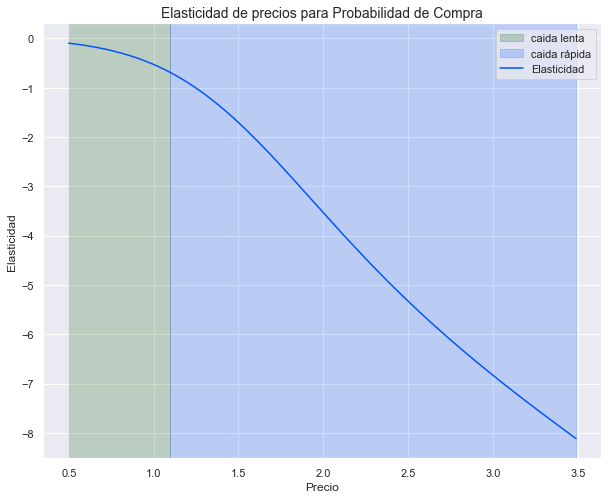

In [14]:
fig, ax = plt.subplots(figsize = (10,8))
ax.set_title("Elasticidad de precios para Probabilidad de Compra", fontsize = 14)
ax.set_xlabel("Precio")
ax.set_ylabel("Elasticidad")
ax.axvspan(0.5, 1.1, color = "#005500", alpha=0.2, label = "caida lenta")
ax.axvspan(1.1, 3.49, color = "#0055ff", alpha=0.2, label = "caida rápida")
ax.plot(master_elasticidades["precio"],master_elasticidades["elasticidad media"], color = "#0055ff",label = "Elasticidad")
plt.legend()
plt.show()

%%latex

#### Comentarios sobre gráfico de elasticidad para la probabilidad de compra

- A medida que el precio crece, la probabilidad de compra de barras de chocolate decrece (nada nuevo por ahora).
- La caida en la probabilidad de compra sucede *a diferentes velocidades* según el precio. Por ejemplo, entre 0.5USD y 1.1USD la caída es lenta (superficie en verde), mientras que desde 1.1USD en adelante, la caída en la probabilida de compra empieza a caer rápidamente (superficie en azul).
- Los valores de elasticidad son todos negativos. En este caso particular, vimos que el coeficiente obtenido por el modelo era de $-2.35$, lo cual genera una pendiente negativa en el gráfico. Esto nos dice que la relación entre precios y probabilidad de compra es una relación *inversamente proporcional*. No obstante, debemos tener en cuenta que **no siempre** tendremos valores negativos de elasticidad, como veremos más adelante.

En escencia,

\textcolor[HTML]{0055ff}{la elasticidad mide el \emph{cambio porcentual} en la \textbf{variable de salida}, que en nuestro caso es la \textbf{probabilidad de compra}, dado un \emph{cambio porcentual} en la \textbf{variable de entrada}, que en nuestro caso es el \textbf{precio de las barras de chocolate}}

Ahora bien, si el cambio porcentual es **mayor al $100\%$** decimos que la salida (probabilidad de compra) es **elástica**, sino decimos que es **inelástica**. Es decir,

$$ |E| < 1 ~ Inelástico $$
$$ |E| > 1 ~ Elástico $$

Analicemos esto con valores numéricos.

- *Rango inelástico*: Tomemos el caso del precio en 1.1USD. ¿Cuánta será la variación en la probabilidad de compra?

In [15]:
master_elasticidades[master_elasticidades["precio"] == 1.1]

,precio,elasticidad media
60,1.1,-0.691946


Podemos ver que cuando el precio de la barra de chocolate es de 1.1USD, el valor de elasticidad es de $-0.691$. Esto implica que **por cada cambio en 1% del precio, la probabilidad de compra cambiará en un valor de $-0.691\%$**. Por lo tanto, esperamos una caída en la probabilidad de compra de $-0.691\%$.

- *Rango elástico*:  Tomemos el caso del precio en 1.5USD. ¿Cuánta será la variación en la probabilidad de compra?

In [16]:
master_elasticidades[master_elasticidades["precio"] == 1.5]

,precio,elasticidad media
100,1.5,-1.702812


Para el precio en 1.5USD la elasticidad es de $-1.70$. Esto implica que **por cada cambio en 1% del precio, la probabilidad de compra cambiará en un valor de $-1.70\%$**. Por lo tanto, esperamos una caida de casi $2\%$ en la probabilidad de compra.

### ¿Por qué es importante la distinción entre rango *inelástico* y el rango *elástico*?

Cuando los valores de elasticidad son inelásticos, la recomendación general es **incrementar los precios** ya que se espera que dicho incremento no cause un significativo decrecimiento en la variable de salida, es decir, en la probabilidad de compra.

Por otro lado, cuando los valores de elasticidad son elásticos (valores más grandes que 1 en valor absoluto), la recomendación es **disminuir** los precios.

¿En qué punto los valores pasan de ser inelásticos a elásticos en nuestro set de datos?

In [17]:
# np.abs(master_elasticidades[np.abs(master_elasticidades["elasticidad media"]) < 1.].iloc[-1])
master_elasticidades[np.round(np.abs(master_elasticidades["elasticidad media"]),2) == 1.]

,precio,elasticidad media
75,1.25,-1.004634


Para nuestros datos, el precio cuando se cumple $|E|<1$ es de 1.25USD.

Esto nos deja la siguiente conclusión.

> Para precios por debajo de 1.25USD podríamos incrementar el valor de una barra de chocolate sin perder mucho en términos de probabilidad de compra. Por otro lado, para precios por encima de 1.25USD, podríamos ganar al reducir los precios.

En el siguiente gráfico vemos las regiones inelásticas y elásticas en colores verde y rojo, respectivamente.

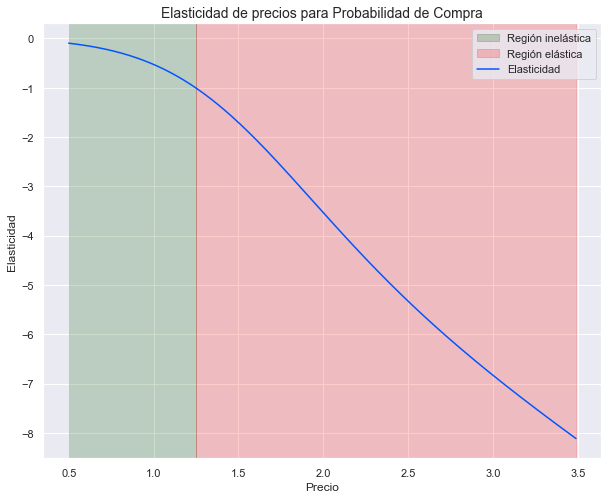

In [18]:
fig, ax = plt.subplots(figsize = (10,8))
ax.set_title("Elasticidad de precios para Probabilidad de Compra", fontsize = 14)
ax.set_xlabel("Precio")
ax.set_ylabel("Elasticidad")
ax.axvspan(0.5, 1.25, color = "#005500", alpha=0.2, label = "Región inelástica")
ax.axvspan(1.25, 3.49, color = "#ff0000", alpha=0.2, label = "Región elástica")
ax.plot(master_elasticidades["precio"],master_elasticidades["elasticidad media"], color = "#0055ff", label = "Elasticidad")
plt.legend()
plt.show()

### Conclusiones

Hemos utilizado la definición de elasticidad para analizar en que dirección y con qué magnitud puede cambiar la probabilidad de compra de las barras de chocolate. Recordemos que el análisis esta referido al cliente *promedio* ya que hemos entrenado el modelo de regresión lineal sobre los valores medios de precios considerando la compra de cualquiera de las 5 marcas.

No obstante, sería interesante observar los cambios en la probabilidad de compra de barras de chocolates ante cambios de precios en una marca en particular -*own-price elasticity*- y al mismo tiempo, evaluada para im segmento de cliente. Y mejor aún, comparar elasticidades respecto de una marca, por ejemplo, marca 5, versus una marca diferente y así sacar conclusiones de si el cambio en el precio de por ejemplo, la marca 4, tendría un impacto positivo o negativo en la probabilida de compra de la marca 5 en el segmento 3.